# Which U.S. state has contributed the most CO₂ emissions from electricity generation since 1990?
## Introduction
In this case study, I explore greenhouse gas emissions from the U.S. electric power industry using SQL in Google BigQuery and Google Sheets for the charts. The [dataset, published by the U.S. Energy Information Administration](https://www.eia.gov/electricity/data.php#elecenv), contains annual emissions estimates dating back to 1990, and as recent as 2023. It includes data on carbon dioxide (CO₂), sulfur dioxide (SO₂), and nitrogen oxides (NOₓ) emissions across all U.S. states, categorized by producer type and energy source.
The EIA is known for its rigorous data collection methods and is widely regarded as a highly reliable source for energy-related statistics. Its data is frequently used by researchers, policy makers, and analysts to monitor trends and shape climate policy.

The goal of this analysis is to determine which U.S. state has contributed the most CO₂ emissions from electricity generation since 1990. By analyzing long-term trends and aggregating emissions by state, this project highlights regional contributions to climate change and demonstrates how structured query language (SQL) can be used to extract meaningful insights from public environmental data.

**Important: The code below will not be functional, as Kaggle cannot execute SQL from the BigQuery sandbox. I will be documenting my process here without running the code.**
While there is an option to run SQL on Kaggle using Python, doing so would not align with the objective of this project.

## Cleaning the data
Starting off with basic cleaning - checking for NULLs

In [ ]:
SELECT 
    COUNT(*) AS total_rows,
    COUNTIF(State IS NULL) AS null_states,
    COUNTIF('CO2Metric Tons' IS NULL) AS null_co2,
    COUNTIF(Year IS NULL) AS null_year
FROM 'delta-exchange-387814.Annual_emissions.Annual_emissions'

```Row | total_rows | null_states | null_co2 | null_year```

``` 1  |   49106    |     0       |    0     |    0```

I did not find any NULL values; however, I will keep NULL filters in place for future-proofing and to ensure overall data safety.

In [ ]:
SELECT *
FROM 'delta-exchange-387814.Annual_emissions.Annual_emissions'
WHERE 
  'CO2Metric Tons' IS NOT NULL 
  AND State IS NOT NULL
  AND Year IS NOT NULL;

```Row |NOxMetricTons |SO2MetricTons |CO2MetricTons |EnergySource |ProducerType |State |Year```

```6  | 7837         | 2403         |2814130       |All Sources  |Electric Utility |AK |1990```

```7  | 2881         | 832          |646430        |Coal         |Electric Utility |AK |1990``` 

```8  | 4364         | 9            |1886585       |Natural Gas  |Electric Utility |AK |1990```

```9  |592           |1562          |281115        |Petroleum    |Electric Utility |AK |1990```

```10 | 791          | 2968         |176547        |All Sources  |Industrial Cogen |AK |1990```

```11 | 308          | 1            |127455        |Natural Gas  |Industrial Cogen |AK |1990```

These are 6 random results out of 49106 that were returned.

## Analysing the data
 Aggregating CO₂ emissions by state

In [ ]:
SELECT 
  State,
  SUM('CO2Metric Tons') AS total_co2_emissions
FROM 
  'delta-exchange-387814.Annual_emissions.Annual_emissions'
WHERE 
  'CO2Metric Tons' IS NOT NULL 
  AND State IS NOT NULL
  AND Year IS NOT NULL
GROUP BY State
ORDER BY total_co2_emissions DESC
LIMIT 10;

This has returned the top 10 states with the highest total CO₂ emissions since 1990

```Row | State    | total_co2_emissions```

```1   | US-TOTAL | 291360127364```

```2   | TX       | 32569574256```

```3   | FL       | 15282684864```

```4   | OH       | 14551200360```

```5   | PA       | 14505692980```

```6   | IN       | 13950303292```

```7   | IL       | 11177805620```

```8   | KY       | 10619925464```

```9   | WV       | 9854772096```

```10  | MI       | 9546492216```

This has included 'US total' as one of the states, so let's remove that to identify our final missing top 10 state:

In [ ]:
SELECT 
  State,
  SUM('CO2Metric Tons') AS total_co2_emissions
FROM 
  'delta-exchange-387814.Annual_emissions.Annual_emissions'
WHERE 
  'CO2Metric Tons' IS NOT NULL 
  AND State IS NOT NULL
  AND Year IS NOT NULL
  AND UPPER(TRIM(State)) != 'US-TOTAL'
GROUP BY State
ORDER BY total_co2_emissions DESC
LIMIT 10;

```Row | State    | total_co2_emissions```

```1   | TX       | 32569574256```

```2   | FL       | 15282684864```

```3   | OH       | 14551200360```

```4   | PA       | 14505692980```

```5   | IN       | 13950303292```

```6   | IL       | 11177805620```

```7   | KY       | 10619925464```

```8   | WV       | 9854772096```

```9   | MI       | 9546492216```

```10  | GA       | 9305286372```

We can now see the **top 10 US states with the highest total CO₂ emissions**, ranked from highest to lowest, with *Texas* at the top of the list.

Let's find out what our most recent available year is, to ensure our dataset contains up-to-date data:

In [ ]:
SELECT MAX(Year) AS most_recent_year
FROM 'delta-exchange-387814.Annual_emissions.Annual_emissions'

```Row | most_recent_year```

``` 1  |     2023```

The most recent year in our dataset is 2023, so it is still quite up-to-date. 

Now, we can examine the list of the **"top 10 US states with the highest total CO₂ emissions" for this most recent year, 2023:**

In [ ]:
SELECT 
  State,
  SUM('CO2Metric Tons') AS total_co2_emissions
FROM 
  'delta-exchange-387814.Annual_emissions.Annual_emissions'
WHERE 
  Year = 2023
AND UPPER(TRIM(State)) != 'US-TOTAL'
GROUP BY State
ORDER BY total_co2_emissions DESC
LIMIT 10;

```Row | State | total_co2_emissions```

```1   | TX    | 851074624```

```2   | FL    | 374939212```

```3   | PA    | 280829388```

```4   | OH    | 252903052```

```5   | IN    | 245009488```

```6   | KY    | 200157876```

```7   | MI    | 200073884```

```8   | AL    | 184326700```

```9   | MO    | 183662508```

```10  | WV    | 182972256```

When examining only the year 2023, our list of states with the highest CO₂ emissions differs slightly from the previous list that included all combined years. *Texas* still holds the top position for the highest CO₂ emissions. However, *Illinois*, which was previously in the top six, and *Georgia*, which was previously in the top ten, are no longer on the list. Instead, *Alabama* has now moved up to eighth place, and *Missouri* is at ninth place.

To go the extra mile, I decided to create a list of the **top 10 energy sources that produce the most emissions.** Similar to the issue I encountered with the 'US Total' earlier, this query was also including 'All Sources', which I have filtered out.

In [ ]:
SELECT 
  'Energy Source',
  SUM('CO2Metric Tons') AS total_co2_emissions
FROM 
  'delta-exchange-387814.Annual_emissions.Annual_emissions'
WHERE 
  'CO2Metric Tons' IS NOT NULL 
  AND State IS NOT NULL
  AND Year IS NOT NULL
  AND UPPER(TRIM('Energy Source')) != 'ALL SOURCES'
GROUP BY 'Energy Source'
ORDER BY total_co2_emissions DESC
LIMIT 10;

```Row | Energy Source | total_co2_emissions```

```1   |     Coal      | 219014122264```

```2   |  Natural Gas  | 61331442980```

```3   |   Petroleum   | 9156482596```

```4   |    Other      | 1800729744```

```5   |   Geothermal  | 53750156```

```6   |  Other Gases  | 3599624```

```7   | Other Biomass | 0```

```8   |Wood and Wood Derived Fuels | 0```

Coal is at the top of the list, with the highest amount of CO₂ emissions.
Here I also noticed that "Other Biomass" and "Wood and Wood Derived Fuels" shows 0 CO₂ emissions, despite having values for  SO₂ and NOₓ in the source dataset. Upon reviewing the EIA's notes and methodology, I realised that this is not a data error. These energy sources are considered biogenic fuels, and their CO₂ emissions are often excluded from fossil fuel emission totals. This approach aligns with international carbon accounting agreement, which consider biogenic CO₂ part of the natural carbon cycle. Essentially, the main idea is that any carbon emitted during combustion will be absorbed over the lifetime of the plants that replace them.

## Identifying trends

**How have total CO₂ emissions changed in the U.S. over time?**

In [ ]:
SELECT 
  Year,
  SUM('CO2Metric Tons') AS total_us_emissions
FROM 
  'delta-exchange-387814.Annual_emissions.Annual_emissions'
WHERE 
  'CO2Metric Tons' IS NOT NULL 
  AND UPPER(TRIM(State)) != 'US-TOTAL'
GROUP BY Year
ORDER BY Year;

```Row | Year | total_us_emissions```

```1   | 1990 | 7814795768```

```2   | 1991 | 7801862828```

```3   | 1992 | 7889100436```

```4   | 1993 | 8228210400```

```5   | 1994 | 8352553604```

```6   | 1995 | 8432024380```

```7   | 1996 | 8747918564```

```8   | 1997 | 9037286080```

```9   | 1998 | 9406398068```

```10  | 1999 | 9465209184```

```11  | 2000 | 9883337780```

```12  | 2001 | 9674426892```

```13  | 2002 | 9695852360```

```14  | 2003 | 9780377200```

```15  | 2004 | 9947926232```

```16  | 2005 | 10175352652```

```17  | 2006 | 9955671004```

```18  | 2007 | 10188129944```

```19  | 2008 | 9936048444```

```20  | 2009 | 9078030512```

```21  | 2010 | 9554383660```

```22  | 2011 | 9148282920```

```23  | 2012 | 8627499108```

```24  | 2013 | 8689419860```

```25  | 2014 | 8673137100```

```26  | 2015 | 8125809052```

```27  | 2016 | 7713603648```

```28  | 2017 | 7398999204```

```29  | 2018 | 7489318096```

```30  | 2019 | 6899490744```

```31  | 2020 | 6214343272```

```32  | 2021 | 6607645224```

```33  | 2022 | 6601466052```

```34  | 2023 | 6126217092```

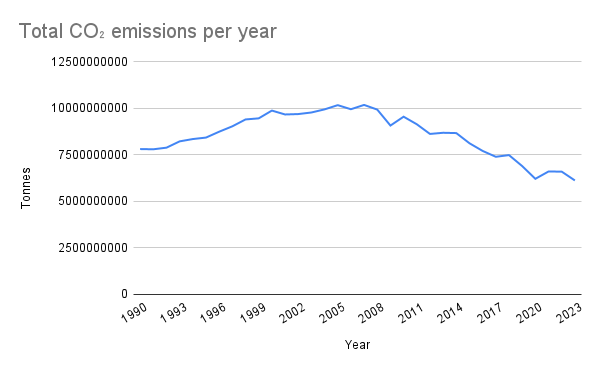

Based on this data, we can see that CO₂ emissions in the US have been consistently declining over the past couple of decades. This downward trend is likely driven by the gradual phasing-out of coal, historically the most carbon-intensive energy source, by natural gas, which emits less CO₂, and by the increasing adoption of renewable energy sources such as wind, solar, and hydro. The overall trend highlights the importance of transitioning to cleaner sources, although coal and natural gas still remain dominant contributors to overall emissions.


**Which energy sources have been driving emissions, and how are they changing over time? Filtered by our top 5 sources:**

In [ ]:
SELECT 
  Year,
  'Energy Source',
  SUM('CO2Metric Tons') AS total_emissions
FROM 
  'delta-exchange-387814.Annual_emissions.Annual_emissions'
WHERE 
  'CO2Metric Tons' IS NOT NULL
  AND UPPER(TRIM('Energy Source')) IN ('COAL', 'NATURAL GAS', 'PETROLEUM', 'OTHER', 'GEOTHERMAL')
GROUP BY Year, 'Energy Source'
ORDER BY Year;

The first 10 rows, out of the 170 that were returned:

```Row | Year | EnergySource | total_emissions```

```1   | 1990 |    Coal      | 6369579380```

```2   | 1990 |  Petroleum   | 478320236```

```3   | 1990 |  Natural Gas | 935406784```

```4   | 1990 |    Other     | 29953400```

```5   | 1990 |  Geothermal  | 1535968```

```6   | 1991 |    Coal      | 6368742932```

```7   | 1991 |  Natural Gas | 952335156```

```8   | 1991 |  Petroleum   | 445405892```

```9   | 1991 |    Other     | 33788476```

```10  | 1991 |  Geothermal  | 1590372```

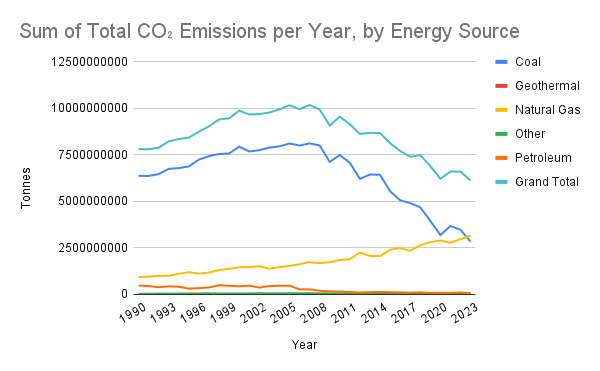

This chart shows US CO₂ emissions by energy source from 1990 to 2023. Among these sources, coal stands out as historically the most polluting. According to US Energy Information Administration, coal emits more CO₂ per unit of energy produced than any other major fuel source - nearly twice as much as natural gas, and more than petroleum.

However, starting around 2008, we see a decline in coal-related emissions. This trend can be attributed to a combination of stricter environmental regulations, the retirement of coal plants, and a shift toward cleaner energy sources like natural gas, wind, and solar. While natural gas is still a fossil fuel, it emits significantly less CO₂ than coal and has become a leading energy source in recent years - as seen in the rising yellow line. 

The steady decline in coal emissions has played a crucial role in driving down overall CO₂ emissions in the US, as reflected in the “Grand Total” line.

**How have emissions changed over time in the top emitting states?**

In [ ]:
SELECT 
  Year,
  State,
  SUM('CO2Metric Tons') AS total_emissions
FROM 
  'delta-exchange-387814.Annual_emissions.Annual_emissions'
WHERE 
  'CO2Metric Tons' IS NOT NULL 
  AND TRIM(State) IN ('TX', 'FL', 'OH', 'PA', 'IN')
GROUP BY Year, State
ORDER BY Year;

The first 10 rows, out of the 170 that were returned:

```Row | Year | State | total_emissions```

```1   | 1990 |  FL   | 366220948```

```2   | 1990 |  IN   | 396314376```

```3   | 1990 |  OH   | 442429364```

```4   | 1990 |  PA   | 437987204```

```5   | 1990 |  TX   | 852224672```

```6   | 1991 |  FL   | 392073960```

```7   | 1991 |  IN   | 394288636```

```8   | 1991 |  OH   | 452618092```

```9   | 1991 |  PA   | 435267508```

```10  | 1991 |  TX   | 849459932```

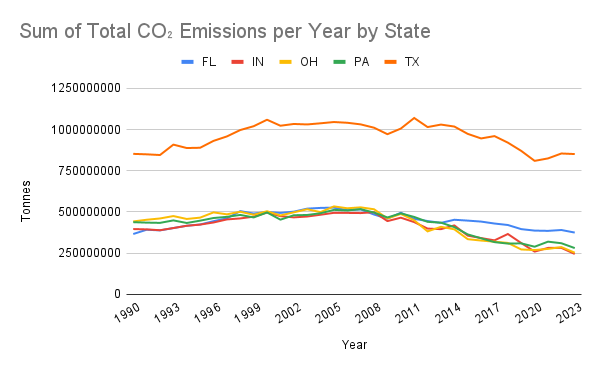

This line chart displays the total annual CO₂ emissions from the top 5 most emitting US states between 1990 and 2023. Texas stands out significantly as the top emitter, a state that is still heavily dependant on fossil fuels. According to EnvironmentAmerica.org, Texas extracts, produces and refines more crude oil and natural gas than any other state, and still remains the largest consumer of coal in the United States. 

In contrast, states like Indiana, Ohio, and Pennsylvania, which have historically relied heavily on coal, show a significant drop in emissions over time. This aligns with the broader national trend of retiring coal plants and adopting cleaner energy sources. These three states begin to sharply decline around 2010, likely due to the combination of stricter environmental regulations, a shift to natural gas, and increasing renewable energy adoption.
Florida maintains relatively steady emissions through the early 2000s, with a slower decline beginning after 2008. 

## Conclusion
This analysis of the US electric power industry reveals that the overall CO₂ emissions have declined since the 1990's, largely due to the gradual phasing-out of coal, with cleaner energy like natural gas and renewables. However, the data also highlights that Texas is the top CO₂ emitter in the country. Given Texas'size (the second-largest state by area) and population (the second-largest state by population), this is not surprising, but it also makes Texas a very critical player in the country's de-carbonization.

**What does this mean for Texas?**

The impacts of climate change are already being felt in Texas, with the state experiencing more frequent heatwaves, prolonged droughts, and extreme weather events. Along much of the coast, sea levels are rising by nearly two inches (~5 cm) per decade. On top of that, increased temperatures can have serious health effects, particularly on vulnerable populations, including children, the elderly, the sick, and those living in poverty. High temperatures can lead to heat stroke, and dehydration, and adversely affect cardiovascular and nervous systems, [as noted by the United States Environmental Protection Agency.](https://www.epa.gov/sites/default/files/2016-09/documents/climate-change-tx.pdf)

Looking ahead, climate projections indicate greater strain on water resources, agriculture, energy infrastructure, and public health - especially if emissions remain high. The data is clear: Texas urgently needs to transition to low-carbon technologies, not only to reduce emissions but also to mitigate the growing effects and risks posed by climate change.